In [1]:
import random, time, os, sys, json
from tqdm import tqdm

In [2]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

In [4]:
'''
{2: [2],
 4: [2, 4],
 8: [2, 8],
 16: [2, 4, 16],
 32: [2, 32],
 64: [2, 4, 8, 64],
 128: [2, 128],
 256: [2, 4, 16, 256],
 512: [2, 8, 512],
 1024: [2, 4, 32, 1024],
 2048: [2, 2048],
 4096: [2, 4, 8, 16, 64, 4096],
 8192: [2, 8192],
 16384: [2, 4, 128, 16384]}
 '''

'\n{2: [2],\n 4: [2, 4],\n 8: [2, 8],\n 16: [2, 4, 16],\n 32: [2, 32],\n 64: [2, 4, 8, 64],\n 128: [2, 128],\n 256: [2, 4, 16, 256],\n 512: [2, 8, 512],\n 1024: [2, 4, 32, 1024],\n 2048: [2, 2048],\n 4096: [2, 4, 8, 16, 64, 4096],\n 8192: [2, 8192],\n 16384: [2, 4, 128, 16384]}\n '

In [281]:
bench_dict = {}

# PREFIX = ""
PREFIX = "r-LN-"
# PREFIX = "r-BN-"
# PREFIX = "r-LN-Rand-"
# PREFIX = "r-BN-Rand-"

def load_json(model_name):
#     fil = f'./models/stats/{PREFIX+model_name}_stats.json'
    fil = f'./models/stats_v1/{PREFIX+model_name}_stats.json'
    if not os.path.exists(fil):
        print(f"File Not Found: {fil}")
        return
    with open(fil) as f:
        data = json.load(f)
    bench_dict[model_name] = data
    return

In [282]:
#### These include incorrect computation (maybe use of torch.bmm ?? also for 2x2 grid function)
# LN-cifar10_ResBlockMLP_b64_h4_s1 macs: 81930.0
# LN-cifar10_ResBlockMLP_b16_h4_s1 macs: 98314.0
# LN-cifar10_ResBlockMLP_b8_h4_s1 macs: 114698.0
# LN-cifar10_ResBlockMLP_b4_h4_s1 macs: 147466.0
# LN-cifar10_ResBlockMLP_b2_h4_s1 macs: 245770.0

# LN-cifar10_SimpleBlockMLP_b64_s1 macs: 53258.0
# LN-cifar10_SimpleBlockMLP_b16_s1 macs: 57354.0
# LN-cifar10_SimpleBlockMLP_b8_s1 macs: 61450.0
# LN-cifar10_SimpleBlockMLP_b4_s1 macs: 69642.0
# LN-cifar10_SimpleBlockMLP_b2_s1 macs: 94218.0

# LN-cifar10_SparseMLP_b64_s1 macs: 49162.0
# LN-cifar10_SparseMLP_b16_s1 macs: 49162.0
# LN-cifar10_SparseMLP_b8_s1 macs: 49162.0
# LN-cifar10_SparseMLP_b4_s1 macs: 49162.0
# LN-cifar10_SparseMLP_b2_s1 macs: 49162.0

# LN-cifar10_SparseMLP_PWLF_b64_s1 macs: 45066.0
# LN-cifar10_SparseMLP_PWLF_b16_s1 macs: 45066.0
# LN-cifar10_SparseMLP_PWLF_b8_s1 macs: 45066.0
# LN-cifar10_SparseMLP_PWLF_b4_s1 macs: 45066.0
# LN-cifar10_SparseMLP_PWLF_b2_s1 macs: 45066.0

# LN-cifar10_OrdinaryMLP_s1 macs: 16830474.0

# BN-cifar10_ResBlockMLP_b64_h4_s1 macs: 86026.0
# BN-cifar10_SimpleBlockMLP_b64_s1 macs: 57354.0
# BN-cifar10_SparseMLP_b64_s1 macs: 53258.0
# BN-cifar10_SparseMLP_PWLF_b64_s1 macs: 49162.0
# BN-cifar10_ResBlockMLP_b16_h4_s1 macs: 102410.0
# BN-cifar10_SimpleBlockMLP_b16_s1 macs: 61450.0
# BN-cifar10_SparseMLP_b16_s1 macs: 53258.0
# BN-cifar10_SparseMLP_PWLF_b16_s1 macs: 49162.0
# BN-cifar10_ResBlockMLP_b8_h4_s1 macs: 118794.0
# BN-cifar10_SimpleBlockMLP_b8_s1 macs: 65546.0
# BN-cifar10_SparseMLP_b8_s1 macs: 53258.0
# BN-cifar10_SparseMLP_PWLF_b8_s1 macs: 49162.0
# BN-cifar10_ResBlockMLP_b4_h4_s1 macs: 151562.0
# BN-cifar10_SimpleBlockMLP_b4_s1 macs: 73738.0
# BN-cifar10_SparseMLP_b4_s1 macs: 53258.0
# BN-cifar10_SparseMLP_PWLF_b4_s1 macs: 49162.0
# BN-cifar10_ResBlockMLP_b2_h4_s1 macs: 249866.0
# BN-cifar10_SimpleBlockMLP_b2_s1 macs: 98314.0
# BN-cifar10_SparseMLP_b2_s1 macs: 53258.0
# BN-cifar10_SparseMLP_PWLF_b2_s1 macs: 49162.0
# BN-cifar10_OrdinaryMLP_s1 macs: 16834570.0

In [283]:
mlp_dims_scale = {
    64: [2, 4, 8],
    16: [2, 4, 8],
    8: [2, 4, 8],
    4: [4, 8, 16],
    2: [4, 8, 16],
}

pwlf_grid_size = [3, 5, 9]

SEEDS = [147, 258, 369]

def load_benchmark_cifar10():
    for seed in SEEDS:
        ## First test MLP with allowed dimension mixing
        for dim, hid_dim in mlp_dims_scale.items(): ## For 1024 these are the factors
            for hr in hid_dim:
                model_name = f"cifar10_BlockMLP_b{dim}_h{hr}_s{seed}"
                load_json(model_name)

            model_name = f"cifar10_SparseMLP_b{dim}_s{seed}"
            load_json(model_name)
            
            #### Simple MLP - Under test: Remove for current working version
            model_name = f"cifar10_SimpleBlockMLP_b{dim}_s{seed}"
            load_json(model_name)
            
            model_name = f"cifar10_SparseMLP_PWLF_b{dim}_s{seed}"
            load_json(model_name)
            
        for gsz in pwlf_grid_size:
            model_name = f"cifar10_PairPWLF_g{gsz}_s{seed}"
            load_json(model_name)
        
        model_name = f"cifar10_OrdinaryMLP_s{seed}"
        load_json(model_name)

In [284]:
load_benchmark_cifar10()

File Not Found: ./models/stats_v1/r-LN-cifar10_BlockMLP_b16_h2_s369_stats.json
File Not Found: ./models/stats_v1/r-LN-cifar10_BlockMLP_b16_h4_s369_stats.json
File Not Found: ./models/stats_v1/r-LN-cifar10_BlockMLP_b16_h8_s369_stats.json
File Not Found: ./models/stats_v1/r-LN-cifar10_SparseMLP_b16_s369_stats.json
File Not Found: ./models/stats_v1/r-LN-cifar10_SparseMLP_PWLF_b16_s369_stats.json
File Not Found: ./models/stats_v1/r-LN-cifar10_BlockMLP_b8_h2_s369_stats.json
File Not Found: ./models/stats_v1/r-LN-cifar10_BlockMLP_b8_h4_s369_stats.json
File Not Found: ./models/stats_v1/r-LN-cifar10_BlockMLP_b8_h8_s369_stats.json
File Not Found: ./models/stats_v1/r-LN-cifar10_SparseMLP_b8_s369_stats.json
File Not Found: ./models/stats_v1/r-LN-cifar10_SparseMLP_PWLF_b8_s369_stats.json
File Not Found: ./models/stats_v1/r-LN-cifar10_BlockMLP_b4_h4_s369_stats.json
File Not Found: ./models/stats_v1/r-LN-cifar10_BlockMLP_b4_h8_s369_stats.json
File Not Found: ./models/stats_v1/r-LN-cifar10_BlockMLP_b

In [285]:
# bench_dict

In [286]:
list(bench_dict.keys())

['cifar10_BlockMLP_b64_h2_s147',
 'cifar10_BlockMLP_b64_h4_s147',
 'cifar10_BlockMLP_b64_h8_s147',
 'cifar10_SparseMLP_b64_s147',
 'cifar10_SimpleBlockMLP_b64_s147',
 'cifar10_SparseMLP_PWLF_b64_s147',
 'cifar10_BlockMLP_b16_h2_s147',
 'cifar10_BlockMLP_b16_h4_s147',
 'cifar10_BlockMLP_b16_h8_s147',
 'cifar10_SparseMLP_b16_s147',
 'cifar10_SimpleBlockMLP_b16_s147',
 'cifar10_SparseMLP_PWLF_b16_s147',
 'cifar10_BlockMLP_b8_h2_s147',
 'cifar10_BlockMLP_b8_h4_s147',
 'cifar10_BlockMLP_b8_h8_s147',
 'cifar10_SparseMLP_b8_s147',
 'cifar10_SimpleBlockMLP_b8_s147',
 'cifar10_SparseMLP_PWLF_b8_s147',
 'cifar10_BlockMLP_b4_h4_s147',
 'cifar10_BlockMLP_b4_h8_s147',
 'cifar10_BlockMLP_b4_h16_s147',
 'cifar10_SparseMLP_b4_s147',
 'cifar10_SimpleBlockMLP_b4_s147',
 'cifar10_SparseMLP_PWLF_b4_s147',
 'cifar10_BlockMLP_b2_h4_s147',
 'cifar10_BlockMLP_b2_h8_s147',
 'cifar10_BlockMLP_b2_h16_s147',
 'cifar10_SparseMLP_b2_s147',
 'cifar10_SimpleBlockMLP_b2_s147',
 'cifar10_SparseMLP_PWLF_b2_s147',
 'cifa

## Filter out the best test acc ones

In [287]:
for k, v in bench_dict.items():
    print(k, max(v['test_acc']))

cifar10_BlockMLP_b64_h2_s147 67.9
cifar10_BlockMLP_b64_h4_s147 68.17
cifar10_BlockMLP_b64_h8_s147 68.82
cifar10_SparseMLP_b64_s147 65.33
cifar10_SimpleBlockMLP_b64_s147 65.32
cifar10_SparseMLP_PWLF_b64_s147 65.81
cifar10_BlockMLP_b16_h2_s147 69.15
cifar10_BlockMLP_b16_h4_s147 70.28
cifar10_BlockMLP_b16_h8_s147 71.48
cifar10_SparseMLP_b16_s147 66.17
cifar10_SimpleBlockMLP_b16_s147 65.32
cifar10_SparseMLP_PWLF_b16_s147 66.99
cifar10_BlockMLP_b8_h2_s147 69.05
cifar10_BlockMLP_b8_h4_s147 70.0
cifar10_BlockMLP_b8_h8_s147 71.02
cifar10_SparseMLP_b8_s147 66.33
cifar10_SimpleBlockMLP_b8_s147 64.31
cifar10_SparseMLP_PWLF_b8_s147 66.32
cifar10_BlockMLP_b4_h4_s147 69.96
cifar10_BlockMLP_b4_h8_s147 71.22
cifar10_BlockMLP_b4_h16_s147 71.56
cifar10_SparseMLP_b4_s147 65.82
cifar10_SimpleBlockMLP_b4_s147 64.45
cifar10_SparseMLP_PWLF_b4_s147 67.15
cifar10_BlockMLP_b2_h4_s147 67.65
cifar10_BlockMLP_b2_h8_s147 68.32
cifar10_BlockMLP_b2_h16_s147 69.5
cifar10_SparseMLP_b2_s147 63.57
cifar10_SimpleBlockMLP_

In [288]:
best_bench = dict()
for k, v in bench_dict.items():
    print(k)
    k = k[:-5]
    if k not in best_bench:
        print("initialize")
        best_bench[k] = v
        print(f'best acc {max(v["test_acc"])}')
    else:
        ## check if this one has higher test acc
        if max(v['test_acc']) > max(best_bench[k]['test_acc']):
            best_bench[k] = v
            print(f'better acc {max(v["test_acc"])}')
        else:
            print(f'worse acc {max(v["test_acc"])}')

    print()

cifar10_BlockMLP_b64_h2_s147
initialize
best acc 67.9

cifar10_BlockMLP_b64_h4_s147
initialize
best acc 68.17

cifar10_BlockMLP_b64_h8_s147
initialize
best acc 68.82

cifar10_SparseMLP_b64_s147
initialize
best acc 65.33

cifar10_SimpleBlockMLP_b64_s147
initialize
best acc 65.32

cifar10_SparseMLP_PWLF_b64_s147
initialize
best acc 65.81

cifar10_BlockMLP_b16_h2_s147
initialize
best acc 69.15

cifar10_BlockMLP_b16_h4_s147
initialize
best acc 70.28

cifar10_BlockMLP_b16_h8_s147
initialize
best acc 71.48

cifar10_SparseMLP_b16_s147
initialize
best acc 66.17

cifar10_SimpleBlockMLP_b16_s147
initialize
best acc 65.32

cifar10_SparseMLP_PWLF_b16_s147
initialize
best acc 66.99

cifar10_BlockMLP_b8_h2_s147
initialize
best acc 69.05

cifar10_BlockMLP_b8_h4_s147
initialize
best acc 70.0

cifar10_BlockMLP_b8_h8_s147
initialize
best acc 71.02

cifar10_SparseMLP_b8_s147
initialize
best acc 66.33

cifar10_SimpleBlockMLP_b8_s147
initialize
best acc 64.31

cifar10_SparseMLP_PWLF_b8_s147
initialize
best

In [289]:
# del best_bench['cifar10_PairPWLF_g9']
# del best_bench['cifar10_PairPWLF_g5']
# del best_bench['cifar10_PairPWLF_g3']

In [290]:
# best_bench["cifar10_SparseMLP_b64"]

## Plot training curve

In [291]:
# plt.figure(figsize=(12, 9))
# for i, (model_name, stat) in enumerate(best_bench.items()):
#     if i < 10:
#         linestyle = None
#     elif i < 20:
#         linestyle='dashed'
#     else:
#         linestyle = 'dashdot'
        
#     plt.plot(stat["train_acc"], label=model_name[8:], linestyle=linestyle)
# plt.legend(ncol=3)

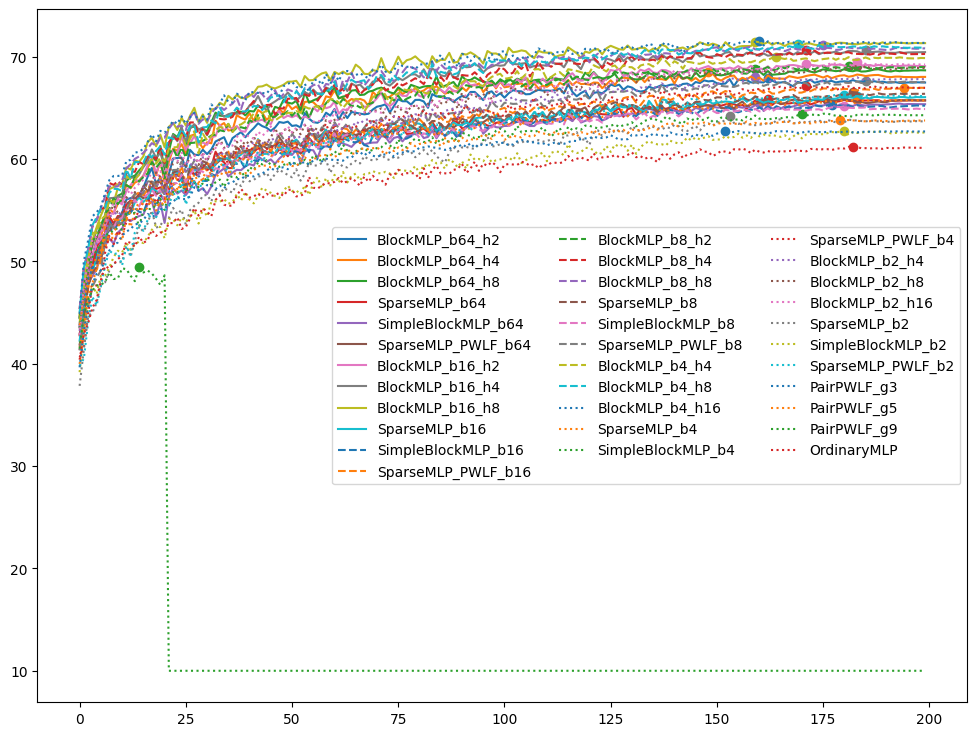

In [292]:
plt.figure(figsize=(12, 9))
for i, (model_name, stat) in enumerate(best_bench.items()):
    if i < 10:
        linestyle = None
    elif i < 20:
        linestyle='dashed'
    else:
        linestyle = 'dotted'

    acc = stat["test_acc"]
    plt.plot(acc, label=model_name[8:], linestyle=linestyle)
    plt.scatter(np.argmax(acc), np.max(acc))
plt.legend(ncol=3)

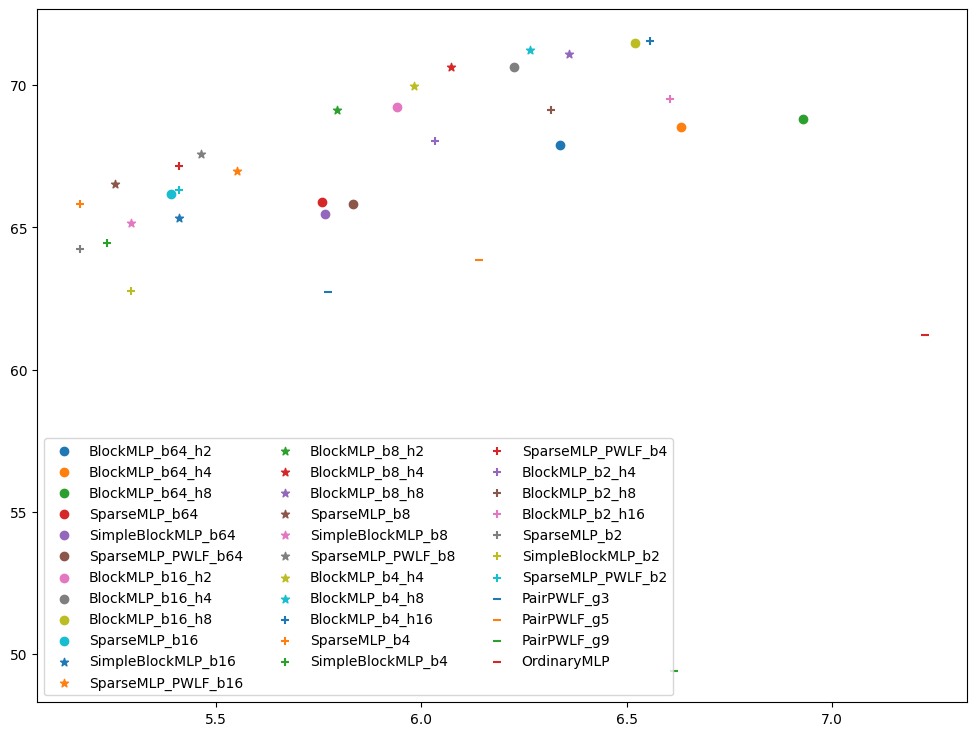

In [293]:
plt.figure(figsize=(12, 9))
for i, (model_name, stat) in enumerate(best_bench.items()):
    if i//10 == 0:
        marker='o'
    elif i//10 == 1:
        marker='*'
    elif i//10 == 2:
        marker='+'
    else:
        marker = '_'

    n_params = stat['num_param']
    n_params = np.log10(n_params)
    
    acc = np.max(stat["test_acc"])
#     acc = np.max(stat["train_acc"])
    plt.scatter(n_params, acc, label=model_name[8:], marker=marker)
plt.legend(ncol=3)

Text(0, 0.5, 'test accuracy')

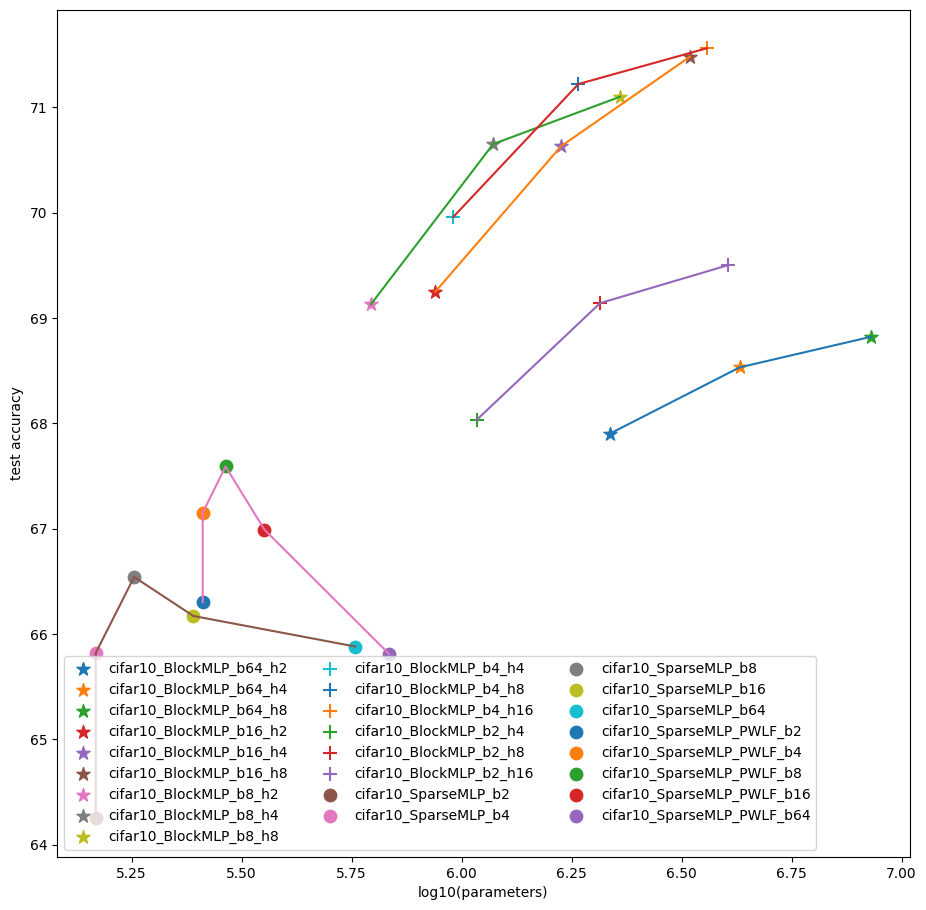

In [294]:
plt.figure(figsize=(11, 11))

## first plot the BlockMLP32
xs, ys = [], [] 
for h in [2, 4, 8]:
    model = 'cifar10_BlockMLP_b64'+f'_h{h}'
    stat = best_bench[model]
    
    n_params = stat['num_param']
    n_params = np.log10(n_params)
    
    acc = np.max(stat["test_acc"])
    xs += [n_params]
    ys += [acc]
    plt.scatter(n_params, acc, label=model, marker='*', s=100)
    
plt.plot(xs, ys)

### Plot for Block 16
xs, ys = [], [] 
for h in [2, 4, 8]:
    model = 'cifar10_BlockMLP_b16'+f'_h{h}'
    stat = best_bench[model]
    
    n_params = stat['num_param']
    n_params = np.log10(n_params)
    
    acc = np.max(stat["test_acc"])
    xs += [n_params]
    ys += [acc]
    plt.scatter(n_params, acc, label=model, marker='*', s=100)
    
plt.plot(xs, ys)

### Plot for Block 8
xs, ys = [], [] 
for h in [2, 4, 8]:
    model = 'cifar10_BlockMLP_b8'+f'_h{h}'
    stat = best_bench[model]
    
    n_params = stat['num_param']
    n_params = np.log10(n_params)
    
    acc = np.max(stat["test_acc"])
    xs += [n_params]
    ys += [acc]
    plt.scatter(n_params, acc, label=model, marker='*', s=100)
    
plt.plot(xs, ys)


### Plot for Block 4
xs, ys = [], [] 
for h in [4, 8, 16]:
    model = 'cifar10_BlockMLP_b4'+f'_h{h}'
    stat = best_bench[model]
    
    n_params = stat['num_param']
    n_params = np.log10(n_params)
    
    acc = np.max(stat["test_acc"])
    xs += [n_params]
    ys += [acc]
    plt.scatter(n_params, acc, label=model, marker='+', s=100)
    
plt.plot(xs, ys)


### Plot for Block 2
xs, ys = [], [] 
for h in [4, 8, 16]:
    model = 'cifar10_BlockMLP_b2'+f'_h{h}'
    stat = best_bench[model]
    
    n_params = stat['num_param']
    n_params = np.log10(n_params)
    
    acc = np.max(stat["test_acc"])
    xs += [n_params]
    ys += [acc]
    plt.scatter(n_params, acc, label=model, marker='+', s=100)
    
plt.plot(xs, ys)

### Plot for sparse Weights
xs, ys = [], [] 
for b in [2, 4, 8, 16, 64]:
    model = f'cifar10_SparseMLP_b{b}'
    stat = best_bench[model]
    
    n_params = stat['num_param']
    n_params = np.log10(n_params)
    
    acc = np.max(stat["test_acc"])
    xs += [n_params]
    ys += [acc]
    plt.scatter(n_params, acc, label=model, marker='o', s=80)
    
plt.plot(xs, ys)

### Plot for sparse Weights + PWLF (b5)
xs, ys = [], [] 
for b in [2, 4, 8, 16, 64]:
    model = f'cifar10_SparseMLP_PWLF_b{b}'
    stat = best_bench[model]
    
    n_params = stat['num_param']
    n_params = np.log10(n_params)
    
    acc = np.max(stat["test_acc"])
    xs += [n_params]
    ys += [acc]
    plt.scatter(n_params, acc, label=model, marker='o', s=80)
    
plt.plot(xs, ys)

# ### Plot for PWLF grids
# xs, ys = [], [] 
# for b in [3, 5]:
#     model = f'cifar10_PairPWLF_g{b}'
#     stat = best_bench[model]
    
#     n_params = stat['num_param']
#     n_params = np.log10(n_params)
    
#     acc = np.max(stat["test_acc"])
#     xs += [n_params]
#     ys += [acc]
#     plt.scatter(n_params, acc, label=model, marker='x', s=100)
    
# plt.plot(xs, ys)

# ### For Ordinary MLP
# model = f'cifar10_OrdinaryMLP'
# stat = best_bench[model]

# n_params = stat['num_param']
# n_params = np.log10(n_params)

# acc = np.max(stat["test_acc"])

# # plt.scatter(n_params, acc, label=model, marker='x', s=100)
# ### The plot below plots for total params and equivalent parameters
# ### (dimension selector parameters are redundent)
# plt.scatter([n_params, n_params+np.log10(3/4)], [acc, acc], label=model, marker='x', s=100)
# plt.plot([n_params, n_params+np.log10(3/4)], [acc, acc])

# plt.ylim((56.5, 72.5))
plt.legend(loc=3, ncol=3)
plt.xlabel("log10(parameters)")
plt.ylabel("test accuracy")

In [295]:
list(best_bench.keys())

['cifar10_BlockMLP_b64_h2',
 'cifar10_BlockMLP_b64_h4',
 'cifar10_BlockMLP_b64_h8',
 'cifar10_SparseMLP_b64',
 'cifar10_SimpleBlockMLP_b64',
 'cifar10_SparseMLP_PWLF_b64',
 'cifar10_BlockMLP_b16_h2',
 'cifar10_BlockMLP_b16_h4',
 'cifar10_BlockMLP_b16_h8',
 'cifar10_SparseMLP_b16',
 'cifar10_SimpleBlockMLP_b16',
 'cifar10_SparseMLP_PWLF_b16',
 'cifar10_BlockMLP_b8_h2',
 'cifar10_BlockMLP_b8_h4',
 'cifar10_BlockMLP_b8_h8',
 'cifar10_SparseMLP_b8',
 'cifar10_SimpleBlockMLP_b8',
 'cifar10_SparseMLP_PWLF_b8',
 'cifar10_BlockMLP_b4_h4',
 'cifar10_BlockMLP_b4_h8',
 'cifar10_BlockMLP_b4_h16',
 'cifar10_SparseMLP_b4',
 'cifar10_SimpleBlockMLP_b4',
 'cifar10_SparseMLP_PWLF_b4',
 'cifar10_BlockMLP_b2_h4',
 'cifar10_BlockMLP_b2_h8',
 'cifar10_BlockMLP_b2_h16',
 'cifar10_SparseMLP_b2',
 'cifar10_SimpleBlockMLP_b2',
 'cifar10_SparseMLP_PWLF_b2',
 'cifar10_PairPWLF_g3',
 'cifar10_PairPWLF_g5',
 'cifar10_PairPWLF_g9',
 'cifar10_OrdinaryMLP']

In [296]:
np.log10(3/4)

-0.12493873660829993

## For train accuracy

In [297]:
# plt.figure(figsize=(11, 11))

# ## first plot the BlockMLP32
# xs, ys = [], [] 
# for h in [2, 4, 8]:
#     model = 'cifar10_BlockMLP_b64'+f'_h{h}'
#     stat = best_bench[model]
    
#     n_params = stat['num_param']
#     n_params = np.log10(n_params)
    
#     acc = np.max(stat["train_acc"])
#     xs += [n_params]
#     ys += [acc]
#     plt.scatter(n_params, acc, label=model, marker='*', s=100)
    
# plt.plot(xs, ys)

# ### Plot for Block 16
# xs, ys = [], [] 
# for h in [2, 4, 8]:
#     model = 'cifar10_BlockMLP_b16'+f'_h{h}'
#     stat = best_bench[model]
    
#     n_params = stat['num_param']
#     n_params = np.log10(n_params)
    
#     acc = np.max(stat["train_acc"])
#     xs += [n_params]
#     ys += [acc]
#     plt.scatter(n_params, acc, label=model, marker='*', s=100)
    
# plt.plot(xs, ys)

# ### Plot for Block 8
# xs, ys = [], [] 
# for h in [2, 4, 8]:
#     model = 'cifar10_BlockMLP_b8'+f'_h{h}'
#     stat = best_bench[model]
    
#     n_params = stat['num_param']
#     n_params = np.log10(n_params)
    
#     acc = np.max(stat["train_acc"])
#     xs += [n_params]
#     ys += [acc]
#     plt.scatter(n_params, acc, label=model, marker='*', s=100)
    
# plt.plot(xs, ys)


# ### Plot for Block 4
# xs, ys = [], [] 
# for h in [4, 8, 16]:
#     model = 'cifar10_BlockMLP_b4'+f'_h{h}'
#     stat = best_bench[model]
    
#     n_params = stat['num_param']
#     n_params = np.log10(n_params)
    
#     acc = np.max(stat["train_acc"])
#     xs += [n_params]
#     ys += [acc]
#     plt.scatter(n_params, acc, label=model, marker='+', s=100)
    
# plt.plot(xs, ys)


# ### Plot for Block 2
# xs, ys = [], [] 
# for h in [4, 8, 16]:
#     model = 'cifar10_BlockMLP_b2'+f'_h{h}'
#     stat = best_bench[model]
    
#     n_params = stat['num_param']
#     n_params = np.log10(n_params)
    
#     acc = np.max(stat["train_acc"])
#     xs += [n_params]
#     ys += [acc]
#     plt.scatter(n_params, acc, label=model, marker='+', s=100)
    
# plt.plot(xs, ys)

# ### Plot for sparse Weights
# xs, ys = [], [] 
# for b in [2, 4, 8, 16, 64]:
#     model = f'cifar10_SparseMLP_b{b}'
#     stat = best_bench[model]
    
#     n_params = stat['num_param']
#     n_params = np.log10(n_params)
    
#     acc = np.max(stat["train_acc"])
#     xs += [n_params]
#     ys += [acc]
#     plt.scatter(n_params, acc, label=model, marker='o', s=80)
    
# plt.plot(xs, ys)

# ### Plot for sparse Weights + PWLF (b5)
# xs, ys = [], [] 
# for b in [2, 4, 8, 16, 64]:
#     model = f'cifar10_SparseMLP_PWLF_b{b}'
#     stat = best_bench[model]
    
#     n_params = stat['num_param']
#     n_params = np.log10(n_params)
    
#     acc = np.max(stat["train_acc"])
#     xs += [n_params]
#     ys += [acc]
#     plt.scatter(n_params, acc, label=model, marker='o', s=80)
    
# plt.plot(xs, ys)

# # ### Plot for PWLF grids
# xs, ys = [], [] 
# for b in [3, 5]:
#     model = f'cifar10_PairPWLF_g{b}'
#     stat = best_bench[model]
    
#     n_params = stat['num_param']
#     n_params = np.log10(n_params)
    
#     acc = np.max(stat["train_acc"])
#     xs += [n_params]
#     ys += [acc]
#     plt.scatter(n_params, acc, label=model, marker='x', s=100)
    
# plt.plot(xs, ys)

# ### For Ordinary MLP
# model = f'cifar10_OrdinaryMLP'
# stat = best_bench[model]

# n_params = stat['num_param']
# n_params = np.log10(n_params)

# acc = np.max(stat["train_acc"])
# # plt.scatter(n_params, acc, label=model, marker='x', s=100)

# plt.scatter([n_params, n_params+np.log10(3/4)], [acc, acc], label=model, marker='x', s=100)
# plt.plot([n_params, n_params+np.log10(3/4)], [acc, acc])

# plt.ylim((50, 95))
# plt.legend(loc=3, ncol=3)
# plt.xlabel("log10(parameters)")
# plt.ylabel("train accuracy")

## Visualize Compact

2 147466
4 147466
8 180234
16 245770
64 573450
2 196618
4 172042
8 196618
16 258058
64 581642


Text(0, 0.5, 'test accuracy')

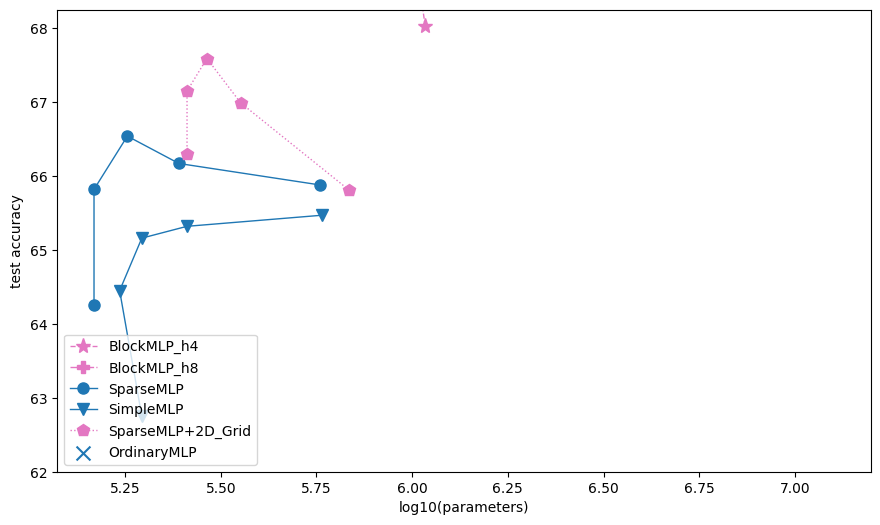

In [298]:
plt.figure(figsize=(10.5, 6))


colors = ["tab:blue",
"tab:orange",
"tab:green",
"tab:red",
"tab:purple",
"tab:brown",
"tab:pink",
"tab:gray",
"tab:olive",
"tab:cyan"]


## first plot the BlockMLP
xs, ys = [], [] 
for i, b in enumerate([2, 4, 8, 16, 64]):
    h = 4
    
    model = f'cifar10_BlockMLP_b{b}_h{h}'
    stat = best_bench[model]
    
    n_params = stat['num_param']
    n_params = np.log10(n_params)
    
    acc = np.max(stat["test_acc"])
    xs += [n_params]
    ys += [acc]
#     plt.scatter(n_params, acc, label=f'Ours_b{b}_h{h}', marker='*', s=110, color=colors[i], edgecolor='k', lw=0.25)
#     plt.scatter(n_params, acc, label=f'Ours_b{b}_h{h}', marker='*', s=110, color=colors[0], lw=0.25)
    
plt.plot(xs, ys, zorder=-1000, lw=1, marker='*', markersize=11, color=colors[6], linestyle="dashed", label=f"BlockMLP_h{h}")

## first plot the BlockMLP
xs, ys = [], [] 
for i, b in enumerate([2, 4, 8, 16, 64]):
    h = 8
    
    model = f'cifar10_BlockMLP_b{b}_h{h}'
    stat = best_bench[model]
    
    n_params = stat['num_param']
    n_params = np.log10(n_params)
    
    acc = np.max(stat["test_acc"])
    xs += [n_params]
    ys += [acc]
#     plt.scatter(n_params, acc, label=f'Ours_b{b}_h{h}', marker='P', s=110, color=colors[1], edgecolor='k', lw=0.25)
    
plt.plot(xs, ys, zorder=-1000, lw=1, marker='P', markersize=8, color=colors[6], linestyle="dashdot", label=f"BlockMLP_h{h}")


### Plot for sparse Weights
xs, ys = [], [] 
for i, b in enumerate([2, 4, 8, 16, 64]):
    model = f'cifar10_SparseMLP_b{b}'
    stat = best_bench[model]
    
    n_params = stat['num_param']
    n_params = np.log10(n_params)
    
    acc = np.max(stat["test_acc"])
    xs += [n_params]
    ys += [acc]
    print(b, stat['num_param'])
#     plt.scatter(n_params, acc, label=f'SparseMLP_b{b}', marker='o', s=80, color=colors[2], edgecolor='k', lw=0.25)
    
plt.plot(xs, ys, zorder=-1000, lw=1, marker='o', markersize=8, color=colors[0], label=f"SparseMLP")

### Plot for sparse Weights
xs, ys = [], [] 
for i, b in enumerate([2, 4, 8, 16, 64]):
    model = f'cifar10_SimpleBlockMLP_b{b}'
    stat = best_bench[model]
    
    n_params = stat['num_param']
    n_params = np.log10(n_params)
    
    acc = np.max(stat["test_acc"])
    xs += [n_params]
    ys += [acc]
    print(b, stat['num_param'])
#     plt.scatter(n_params, acc, label=f'SparseMLP_b{b}', marker='o', s=80, color=colors[2], edgecolor='k', lw=0.25)
    
plt.plot(xs, ys, zorder=-1000, lw=1, marker='v', markersize=8, color=colors[0], label=f"SimpleMLP")

### Plot for sparse Weights + PWLF (b5)
xs, ys = [], [] 

for i, b in enumerate([2, 4, 8, 16, 64]):
    
    model = f'cifar10_SparseMLP_PWLF_b{b}'
    stat = best_bench[model]
    
    n_params = stat['num_param']
    n_params = np.log10(n_params)
    
    acc = np.max(stat["test_acc"])
    xs += [n_params]
    ys += [acc]
#     plt.scatter(n_params, acc, label=f'SparseMLP_b{b}+2D_Grid', marker='p', s=90, color=colors[3], edgecolor='k', lw=0.25)
    
plt.plot(xs, ys, zorder=-1000, lw=1, marker='p', markersize=9, color=colors[6], linestyle="dotted", label=f"SparseMLP+2D_Grid")

# ### Plot for PWLF grids
# xs, ys = [], [] 
# for b in [3, 5]:
#     model = f'cifar10_PairPWLF_g{b}'
#     stat = best_bench[model]
    
#     n_params = stat['num_param']
#     n_params = np.log10(n_params)
    
#     acc = np.max(stat["test_acc"])
#     xs += [n_params]
#     ys += [acc]
#     plt.scatter(n_params, acc, label=model[8:], marker='x', s=100)
    
# plt.plot(xs, ys)

### For Ordinary MLP
model = f'cifar10_OrdinaryMLP'
stat = best_bench[model]

n_params = stat['num_param']
n_params = np.log10(n_params-(1/4*4096*4096))

acc = np.max(stat["test_acc"])

plt.scatter(n_params, acc, label="OrdinaryMLP", marker='x', s=100, c=colors[0])
### The plot below plots for total params and equivalent parameters
### (dimension selector parameters are redundent)
# plt.scatter([n_params, n_params2], [acc, acc], label=model[8:], marker='x', s=100)
# plt.plot([n_params, n_params2], [acc, acc])

# plt.ylim((60, 72.5))
# plt.ylim((64, 72.5))
# plt.ylim((58, 66))
plt.ylim((62, 68.25))

plt.legend(loc=3)
plt.xlabel("log10(parameters)")
plt.ylabel("test accuracy")

# plt.savefig(f"./models/simplified_{PREFIX}cifar10_nonlinear_mixer.pdf", bbox_inches='tight')